In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px
from plotly.subplots import make_subplots
import datetime as dt
from datetime import timedelta
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
#from fbprophet import Prophet
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.stattools import adfuller

std=StandardScaler()
# set up everything so that the figures show up in the notebook
init_notebook_mode(connected=True)

In [2]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from multiprocessing import cpu_count
from joblib import Parallel, delayed
from warnings import catch_warnings, filterwarnings
from statsmodels.tools.eval_measures import rmse, aic

filterwarnings('ignore')

# Indeed data modeling

## Load data

In [3]:
df_indeed = pd.read_csv('/Users/tingtingweng/Documents/summer_intern/data/Indeed_DSJobs_20200816_combined.csv')
df_indeed.head()

,Title,Company,State,Location,Date,Salary,Summary,Description,Code,Post date,Day of week,City
0,Senior Data Analyst,Pack Health,Alabama,"Birmingham, AL 35203 (Fountain Heights area)",2 days ago,NaN,Analyzing and reporting of health outcomes and...,Pack Health is a digital health coaching platf...,AL,2020-08-14,Fri,Birmingham
1,DATA SCIENTIST I,BBVA Continental,Alabama,"Birmingham, AL",3 days ago,NaN,Perform data analytics in support of various b...,"Location: Birmingham, Alabama. United States J...",AL,2020-08-13,Thu,Birmingham
2,DATA SCIENTIST I,BBVA,Alabama,"Birmingham, AL 35233 (Southside area)",3 days ago,NaN,Perform data analytics in support of various b...,Company: Compass Bank dba BBVA Compass Locatio...,AL,2020-08-13,Thu,Birmingham
3,Data Engineer,Riverstone Solutions,Alabama,"Huntsville, AL",3 days ago,NaN,Experience using data analytics and visualizat...,"Full Time Huntsville, AL Job Description: Riv...",AL,2020-08-13,Thu,Huntsville
4,Artificial Intelligence (AI) and Machine Learn...,COLSA,Alabama,"Huntsville, AL 35806",4 days ago,NaN,Work closely with developers and engineers to ...,"General Summary Conducts highly specialized,...",AL,2020-08-12,Wed,Huntsville


In [45]:
df_indeed

,Title,Company,State,Location,Date,Salary,Summary,Description,Code,Post date,Day of week,City
0,Senior Data Analyst,Pack Health,Alabama,"Birmingham, AL 35203 (Fountain Heights area)",2 days ago,NaN,Analyzing and reporting of health outcomes and...,Pack Health is a digital health coaching platf...,AL,2020-08-14,Fri,Birmingham
1,DATA SCIENTIST I,BBVA Continental,Alabama,"Birmingham, AL",3 days ago,NaN,Perform data analytics in support of various b...,"Location: Birmingham, Alabama. United States J...",AL,2020-08-13,Thu,Birmingham
2,DATA SCIENTIST I,BBVA,Alabama,"Birmingham, AL 35233 (Southside area)",3 days ago,NaN,Perform data analytics in support of various b...,Company: Compass Bank dba BBVA Compass Locatio...,AL,2020-08-13,Thu,Birmingham
3,Data Engineer,Riverstone Solutions,Alabama,"Huntsville, AL",3 days ago,NaN,Experience using data analytics and visualizat...,"Full Time Huntsville, AL Job Description: Riv...",AL,2020-08-13,Thu,Huntsville
4,Artificial Intelligence (AI) and Machine Learn...,COLSA,Alabama,"Huntsville, AL 35806",4 days ago,NaN,Work closely with developers and engineers to ...,"General Summary Conducts highly specialized,...",AL,2020-08-12,Wed,Huntsville
...,...,...,...,...,...,...,...,...,...,...,...,...
10477,Supervisory Research Statistician,US Department of Labor,"Washington, DC","Washington, DC",22 days ago,"$142,701 - $170,800 a year",Encourages and nurtures interaction among beha...,Duties Summary The Bureau of Labor Statistics ...,DC,2020-05-26,Tue,Washington
10478,"Supervisory Mathematical Statistician, GS-1529...",US Department of Commerce,"Washington, DC","Suitland, MD",27 days ago,"$121,316 - $157,709 a year",The experience offered in combination with edu...,Duties Summary This vacancy is for a Superviso...,MD,2020-05-21,Thu,Suitland
10479,Full Stack Developer - Data Science,Guidehouse,"Washington, DC","Washington, DC 20006 (Foggy Bottom area)",25 days ago,NaN,As a full stack engineer on the team you will ...,Overview: Interested in working with talented ...,DC,2020-05-23,Sat,Washington
10480,"Machine Learning Engineer, Lead",Booz Allen Hamilton,"Washington, DC","Arlington, VA 22202 (Aurora Highlands area)",27 days ago,NaN,"You’ll mentor teammates, develop algorithms, w...",The Challenge: Are you excited at the prospect...,VA,2020-05-21,Thu,Arlington


In [4]:
bydate = df_indeed.groupby('Post date').size()

df_date_indeed = pd.DataFrame({'Date': bydate.index, 'Jobnums': bydate.values})

In [5]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_date_indeed['Date'], y=df_date_indeed['Jobnums'], mode='lines+markers'))

fig.update_layout(title='Data scientist open positions vs. post date')
fig.show()

In [6]:
df_date_indeed['Date'] = pd.to_datetime(df_date_indeed['Date'])
df_date_indeed.set_index('Date', drop=False, inplace=True)

In [7]:
week = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
df_date_indeed['Day of week'] = df_date_indeed['Date'].apply(lambda x: week[x.weekday()])

In [8]:
df_date_indeed['Weekend'] = df_date_indeed['Day of week'].apply(lambda x: 1 if (x == 'Sun') or (x == 'Sat') else 0)
df_date_indeed.at['2020-05-25','Weekend'] = 1 # memorial day

In [9]:
df_date_indeed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 90 entries, 2020-05-19 to 2020-08-16
Data columns (total 4 columns):
Date           90 non-null datetime64[ns]
Jobnums        90 non-null int64
Day of week    90 non-null object
Weekend        90 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 6.0+ KB


Text(0.5, 0, ' ')

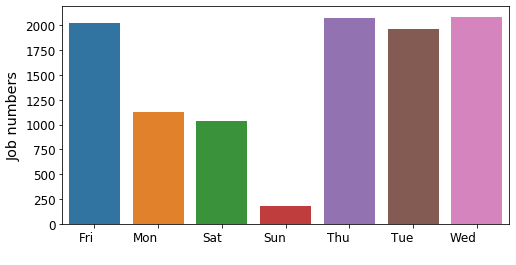

In [10]:
by_weekday = df_date_indeed.groupby('Day of week').sum()
by_weekday.reset_index(inplace=True)
by_weekday

plt.figure(figsize=(8,4))
sns.barplot(x='Day of week', y='Jobnums', data=by_weekday)
plt.xticks(horizontalalignment='right', fontweight='light', fontsize='large')
plt.yticks(fontsize='large')
plt.ylabel('Job numbers', fontsize='x-large')
plt.xlabel(' ')

## Load Covid-19 Data

In [12]:
bydate_us = pd.read_csv('/Users/tingtingweng/Documents/summer_intern/data/us_covid_19_data.csv')
bydate_us.head()

,Date,Confirmed,Deaths,Recovered,Active,New,Fatality
0,2020-01-22,1,0,0,1,0,0.0
1,2020-01-23,1,0,0,1,0,0.0
2,2020-01-24,2,0,0,2,1,0.0
3,2020-01-25,2,0,0,2,0,0.0
4,2020-01-26,5,0,0,5,3,0.0


In [14]:
bydate_us.set_index('Date', drop=True, inplace=True)
bydate_us

,Confirmed,Deaths,Recovered,Active,New,Fatality
Date,,,,,,
2020-01-22,1,0,0,1,0,0.000000
2020-01-23,1,0,0,1,0,0.000000
2020-01-24,2,0,0,2,1,0.000000
2020-01-25,2,0,0,2,0,0.000000
2020-01-26,5,0,0,5,3,0.000000
...,...,...,...,...,...,...
2020-08-13,5248958,167110,1774648,3307200,51547,3.183680
2020-08-14,5313252,168452,1796326,3348474,64294,3.170412
2020-08-15,5361165,169481,1818527,3373157,47913,3.161272


In [15]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=bydate_us.index, y=bydate_us['Confirmed'], mode='lines', name='Confirmed'))
fig.add_trace(go.Scatter(x=bydate_us.index, y=bydate_us['Deaths'], mode='lines', name='Deaths'))
fig.add_trace(go.Scatter(x=bydate_us.index, y=bydate_us['Recovered'], mode='lines', name='Recovered'))
fig.add_trace(go.Scatter(x=bydate_us.index, y=bydate_us['Active'], mode='lines', name='Active'))
fig.add_trace(go.Scatter(x=bydate_us.index, y=bydate_us['New'], mode='lines', name='New'))
fig.add_trace(go.Scatter(x=bydate_us.index, y=bydate_us['Fatality'], mode='lines', name='Fatality Rate'))

fig.update_layout(title='US COVID-19 Cases')
fig.show()

## Combine Data

In [16]:
df_covid_trunc1 = bydate_us['2020-05-19':'2020-08-15']
df_indeed_trunc = df_date_indeed['2020-05-19':'2020-08-15']

df_combined_indeed = pd.concat([df_indeed_trunc, df_covid_trunc1], axis=1)
df_combined_indeed.head()

,Date,Jobnums,Day of week,Weekend,Confirmed,Deaths,Recovered,Active,New,Fatality
Date,,,,,,,,,,
2020-05-19,2020-05-19,45,Tue,0,1535350,94798,289392,1151160,20449,6.174358
2020-05-20,2020-05-20,57,Wed,0,1559157,96377,294312,1168468,23807,6.181353
2020-05-21,2020-05-21,47,Thu,0,1584512,97611,298418,1188483,25355,6.160319
2020-05-22,2020-05-22,51,Fri,0,1608653,98884,350135,1159634,24141,6.147006
2020-05-23,2020-05-23,51,Sat,1,1630476,100014,361239,1169223,21823,6.134037


In [29]:
df_combined_indeed['New']=df_combined_indeed['New'].astype(np.float64)
df_combined_indeed.head()

,Date,Jobnums,Day of week,Weekend,Confirmed,Deaths,Recovered,Active,New,Fatality
Date,,,,,,,,,,
2020-05-19,2020-05-19,45,Tue,0,1535350,94798,289392,1151160,20449.0,6.174358
2020-05-20,2020-05-20,57,Wed,0,1559157,96377,294312,1168468,23807.0,6.181353
2020-05-21,2020-05-21,47,Thu,0,1584512,97611,298418,1188483,25355.0,6.160319
2020-05-22,2020-05-22,51,Fri,0,1608653,98884,350135,1159634,24141.0,6.147006
2020-05-23,2020-05-23,51,Sat,1,1630476,100014,361239,1169223,21823.0,6.134037


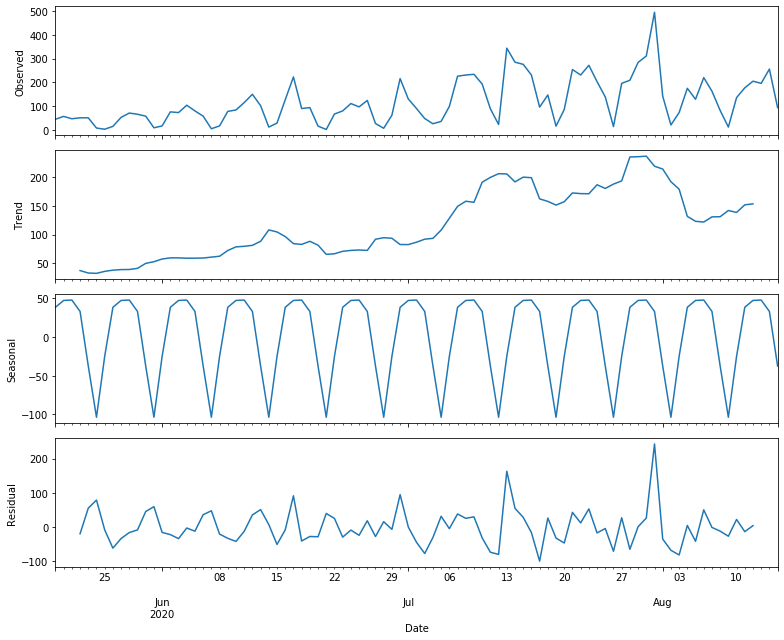

In [17]:
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

y=df_combined_indeed['Jobnums']
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

### Grid Search

In [18]:
def diff_transform(df_train,  d):
    """take difference"""
    df_diff = df_train.copy()
    columns = df_train.columns
    if d>0:
        for col in columns:        
            df_diff[str(col)+'_1d'] = df_diff[col].diff().fillna(0)
            df_diff.drop(columns=[col],inplace=True)
            if d>1:
                df_diff[str(col)+'_2d'] = df_diff[str(col)+'_1d'].diff().fillna(0)
                df_diff.drop(columns=[str(col)+'_1d'],inplace=True)
            
    return df_diff

In [19]:
def invert_transform(df_train, df_forecast, d):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    if d>0:
        for col in columns:        
            # Roll back 2nd Diff
            if d==2:
                df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
                df_fc.drop(columns=[str(col)+'_2d'],inplace=True)
            # Roll back 1st Diff
            df_fc[col] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
            df_fc.drop(columns=[str(col)+'_1d'],inplace=True)
    return df_fc

In [30]:
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

def measure_rmse(actual, predicted):
    return rmse(actual, predicted)

def varmax_forecast(train, test_len, config, exog1=None, exog2=None):
    order, trend, d= config
    #d parameter to take difference
    df_diff = diff_transform(train,  d)
    try:
        model = VARMAX(df_diff, order=order, trend=trend, exog=exog1,initialization='approximate_diffuse')
        model_fit = model.fit(disp=False)
        yhat_diff = model_fit.forecast(steps=test_len, exog=exog2)
        yhat = invert_transform(train, yhat_diff, d)
    except:
        yhat = None
    return yhat

def single_validation(data, n_test, cfg, exog=None):
    train, test = train_test_split(data, n_test)
    if exog is not None:
        exog_train, exog_test = train_test_split(exog, n_test)
        yhat = varmax_forecast(train, len(test), cfg, exog1=exog_train, exog2=exog_test)
    else:
        yhat = varmax_forecast(train, len(test), cfg)
    if yhat is not None:
        error = measure_rmse(test['Jobnums'], yhat['Jobnums'])
    else:
        error = None
    return error

def walk_forward_validation(data, n_test, cfg, exog=None):
    train, test = train_test_split(data, n_test)
    predictions = pd.DataFrame()
    history = train.copy()
    if exog is not None:
        exog_train, exog_test = train_test_split(exog, n_test)
        exog_ = [x[:] for x in exog_train.values]
        for i in range(len(test)):
            yhat = varmax_forecast(history, 1, cfg, exog1=exog_, exog2=np.array(exog_test.iloc[i]).reshape(1,-1))
            predictions = predictions.append(yhat)
            history = history.append(test.iloc[i])
            exog_.append(np.array(exog_test.iloc[i]))
        error = measure_rmse(test['Jobnums'], predictions['Jobnums'])
        return error
    else:
        for i in range(len(test)):
            yhat = varmax_forecast(history, 1, cfg)
            predictions = predictions.append(yhat)
            history = history.append(test.iloc[i])
        error = measure_rmse(test['Jobnums'], predictions['Jobnums'])
        return error

def score_model(data, n_test, cfg, method, exog=None, debug=True):
    result = None
    key = str(cfg)
    if debug:
        if method=='walk':
            result = walk_forward_validation(data, n_test, cfg, exog)
        else:
            result = single_validation(data, n_test, cfg, exog)
    else:
        try:
            with catch_warnings():
                filterwarnings("ignore")
                if method=='walk':
                    result = walk_forward_validation(data, n_test, cfg, exog)
                else:
                    result = single_validation(data, n_test, cfg, exog)
        except:
            result = None
    if result is not None:
        print('---> Model[%s] %.3f' % (key, result))
    return (key, result)

def grid_search(data, cfg_list, n_test, method, exog=None, parallel=True):
    scores = None
    if parallel:
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg, method, exog) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg, method, exog) for cfg in cfg_list]
    scores = [r for r in scores if r[1] != None]
    scores.sort(key=lambda tup: tup[1])
    return scores

def varmax_configs():
    models = list()
    p_params = [3, 4, 5, 6, 7, 8, 9, 10]
    q_params = [0, 1, 2]
    t_params = ['n', 'c', 't', 'ct']
    d_params = [0, 1, 2]
    
    for p in p_params:
        for q in q_params:
            for t in t_params:
                for d in d_params:
                    cfg = [(p,q), t, d]
                    models.append(cfg)
    return models

In [21]:
def walk_forward_best(data, n_test, cfg, exog=None):
    train, test = train_test_split(data, n_test)
    predictions = pd.DataFrame()
    history = train.copy()
    if exog is not None:
        exog_train, exog_test = train_test_split(exog, n_test)
        exog_ = [x[:] for x in exog_train.values]
        for i in range(len(test)):
            yhat = varmax_forecast(history, 1, cfg, exog1=exog_, exog2=np.array(exog_test.iloc[i]).reshape(1,-1))
            predictions = predictions.append(yhat)
            history = history.append(test.iloc[i])
            exog_.append(np.array(exog_test.iloc[i]))
        error = measure_rmse(test['Jobnums'], predictions['Jobnums'])
        return predictions, error
    else:
        for i in range(len(test)):
            yhat = varmax_forecast(history, 1, cfg)
            predictions = predictions.append(yhat)
            history = history.append(test.iloc[i])
        error = measure_rmse(test['Jobnums'], predictions['Jobnums'])
        return predictions, error

#### No eXog + Walk

In [31]:
n_test = 7
cfg_list = varmax_configs()
method = 'walk'
scores = grid_search(df_combined_indeed[['New','Jobnums']], cfg_list, n_test, method, exog=None, parallel=False)
print('n_test:{}, method:{}, best_cfg parameters are:{}, rmse:{}'.format(n_test,method,scores[0][0],scores[0][1]))

---> Model[[(3, 0), 'n', 0]] 69.759
---> Model[[(3, 0), 'n', 1]] 63.555
---> Model[[(3, 0), 'n', 2]] 82.602
---> Model[[(3, 0), 'c', 0]] 70.780
---> Model[[(3, 0), 'c', 1]] 63.358
---> Model[[(3, 0), 'c', 2]] 83.875
---> Model[[(3, 0), 't', 0]] 77.119
---> Model[[(3, 0), 't', 1]] 64.470
---> Model[[(3, 0), 't', 2]] 84.137
---> Model[[(3, 0), 'ct', 0]] 75.189
---> Model[[(3, 0), 'ct', 1]] 64.936
---> Model[[(3, 0), 'ct', 2]] 85.422
---> Model[[(3, 1), 'n', 0]] 62.587
---> Model[[(3, 1), 'n', 1]] 64.207
---> Model[[(3, 1), 'n', 2]] 96.569
---> Model[[(3, 1), 'c', 0]] 68.772
---> Model[[(3, 1), 'c', 1]] 60.427
---> Model[[(3, 1), 'c', 2]] 90.582
---> Model[[(3, 1), 't', 0]] 82.016
---> Model[[(3, 1), 't', 1]] 62.895
---> Model[[(3, 1), 't', 2]] 101.491
---> Model[[(3, 1), 'ct', 0]] 81.737
---> Model[[(3, 1), 'ct', 1]] 68.121
---> Model[[(3, 1), 'ct', 2]] 89.787
---> Model[[(3, 2), 'n', 0]] 66.498
---> Model[[(3, 2), 'n', 1]] 63.709
---> Model[[(3, 2), 'n', 2]] 57.386
---> Model[[(3, 2), '

---> Model[[(9, 0), 'ct', 1]] 36.212
---> Model[[(9, 0), 'ct', 2]] 64.261
---> Model[[(9, 1), 'n', 0]] 22.615
---> Model[[(9, 1), 'n', 1]] 43.377
---> Model[[(9, 1), 'n', 2]] 50.889
---> Model[[(9, 1), 'c', 0]] 91.495
---> Model[[(9, 1), 'c', 1]] 45.315
---> Model[[(9, 1), 'c', 2]] 54.722
---> Model[[(9, 1), 't', 0]] 33.850
---> Model[[(9, 1), 't', 1]] 40.872
---> Model[[(9, 1), 't', 2]] 53.976
---> Model[[(9, 1), 'ct', 0]] 27.825
---> Model[[(9, 1), 'ct', 1]] 42.881
---> Model[[(9, 1), 'ct', 2]] 57.969
---> Model[[(9, 2), 'n', 0]] 30.467
---> Model[[(9, 2), 'n', 1]] 34.330
---> Model[[(9, 2), 'n', 2]] 61.190
---> Model[[(9, 2), 'c', 0]] 32.180
---> Model[[(9, 2), 'c', 1]] 36.445
---> Model[[(9, 2), 'c', 2]] 66.559
---> Model[[(9, 2), 't', 0]] 41.678
---> Model[[(9, 2), 't', 1]] 31.598
---> Model[[(9, 2), 't', 2]] 63.338
---> Model[[(9, 2), 'ct', 0]] 43.960
---> Model[[(9, 2), 'ct', 1]] 31.982
---> Model[[(9, 2), 'ct', 2]] 77.130
---> Model[[(10, 0), 'n', 0]] 23.041
---> Model[[(10, 0)

In [54]:
best_cfg = [(8, 2), 'ct', 0]
n_test = 7
indeed_data = df_combined_indeed[['New','Jobnums']]
train, test = train_test_split(indeed_data, n_test)
yhat_in_varma, error_in_varma = walk_forward_best(indeed_data, n_test, best_cfg)

#### X=weekend + Walk

In [32]:
n_test = 7
cfg_list = varmax_configs()
method = 'walk'
scores = grid_search(df_combined_indeed[['New','Jobnums']], cfg_list, n_test, method, exog=df_combined_indeed[['Weekend']])
print('n_test:{}, method:{}, best_cfg parameters are:{}, rmse:{}'.format(n_test,method,scores[0][0],scores[0][1]))

---> Model[[(3, 0), 'n', 1]] 47.974
---> Model[[(3, 0), 'n', 2]] 57.709
---> Model[[(3, 0), 'n', 0]] 44.146
---> Model[[(3, 0), 'c', 0]] 34.612
---> Model[[(3, 0), 'c', 1]] 15.607
---> Model[[(3, 0), 'c', 2]] 46.218
---> Model[[(3, 0), 't', 0]] 41.067
---> Model[[(3, 0), 't', 1]] 25.961
---> Model[[(3, 0), 't', 2]] 48.814
---> Model[[(3, 0), 'ct', 0]] 35.091
---> Model[[(3, 0), 'ct', 1]] 23.843
---> Model[[(3, 0), 'ct', 2]] 48.422
---> Model[[(3, 1), 'n', 0]] 46.703
---> Model[[(3, 1), 'n', 1]] 44.521
---> Model[[(3, 1), 'n', 2]] 65.279
---> Model[[(3, 1), 'c', 0]] 32.745
---> Model[[(3, 1), 'c', 1]] 21.021
---> Model[[(3, 1), 't', 0]] 43.272
---> Model[[(3, 1), 'c', 2]] 49.086
---> Model[[(3, 1), 't', 1]] 28.698
---> Model[[(3, 1), 't', 2]] 62.889
---> Model[[(3, 1), 'ct', 0]] 37.183
---> Model[[(3, 1), 'ct', 1]] 20.119
---> Model[[(3, 1), 'ct', 2]] 53.646
---> Model[[(3, 2), 'n', 0]] 42.818
---> Model[[(3, 2), 'n', 1]] 47.648
---> Model[[(3, 2), 'c', 0]] 33.142
---> Model[[(3, 2), 'n

---> Model[[(9, 0), 'ct', 1]] 60.041
---> Model[[(9, 0), 'ct', 2]] 135.617
---> Model[[(9, 1), 'n', 0]] 51.952
---> Model[[(9, 1), 'n', 2]] 73.308
---> Model[[(9, 1), 'n', 1]] 52.406
---> Model[[(9, 1), 'c', 0]] 35.199
---> Model[[(9, 1), 'c', 1]] 51.819
---> Model[[(9, 1), 'c', 2]] 108.389
---> Model[[(9, 1), 't', 0]] 19.619
---> Model[[(9, 1), 't', 1]] 42.995
---> Model[[(9, 1), 't', 2]] 73.319
---> Model[[(9, 1), 'ct', 0]] 37.164
---> Model[[(9, 1), 'ct', 1]] 60.018
---> Model[[(9, 1), 'ct', 2]] 139.129
---> Model[[(9, 2), 'n', 0]] 60.923
---> Model[[(9, 2), 'n', 2]] 60.750
---> Model[[(9, 2), 'n', 1]] 47.697
---> Model[[(9, 2), 'c', 0]] 55.403
---> Model[[(9, 2), 'c', 1]] 56.653
---> Model[[(9, 2), 't', 0]] 45.522
---> Model[[(9, 2), 'c', 2]] 91.902
---> Model[[(9, 2), 't', 1]] 47.404
---> Model[[(9, 2), 't', 2]] 72.223
---> Model[[(9, 2), 'ct', 0]] 47.684
---> Model[[(9, 2), 'ct', 1]] 66.550
---> Model[[(10, 0), 'n', 0]] 36.042
---> Model[[(9, 2), 'ct', 2]] 132.893
---> Model[[(10

In [55]:
n_test = 7
best_cfg = [(6, 1), 't', 0]
indeed_data = df_combined_indeed[['New','Jobnums']]
train, test = train_test_split(indeed_data, n_test)
yhat_in_varmax, error_in_varmax = walk_forward_best(indeed_data, n_test, best_cfg, exog=df_combined_indeed[['Weekend']])

In [56]:
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{"colspan": 2}, None],[{}, {}]],
    subplot_titles=("Train data",'No eXog, RMSE: {:0.2f}'.format(error_in_varma), 'X=Weekend, RMSE: {:0.2f}'.format(error_in_varmax)))

fig.add_trace(go.Scatter(x=train.index, y=train['Jobnums'], mode='lines+markers',name='Train', showlegend=False), row=1, col=1)
fig.add_trace(go.Scatter(x=test.index, y=test['Jobnums'], mode='lines+markers',line=dict(color='green'), name='Test', showlegend=False), row=2, col=1)
fig.add_trace(go.Scatter(x=test.index, y=yhat_in_varma["Jobnums"], mode='lines+markers',line=dict(color='red'), name='Prediction',showlegend=False),row=2, col=1)
#fig.add_trace(go.Scatter(x=pred_cix.index, y=pred_ci.iloc[:,1], fill=None, mode='lines',line=dict(width=0.0,color='lightgray'),showlegend=False), row=2, col=1)
#fig.add_trace(go.Scatter(x=pred_cix.index, y=pred_ci.iloc[:,3], fill='tonexty', mode='lines',line=dict(width=0.0,color='lightgray'),showlegend=False),row=2, col=1)
fig.add_trace(go.Scatter(x=test.index, y=test['Jobnums'], mode='lines+markers', line=dict(color='green'), name='Test',showlegend=True), row=2, col=2)
fig.add_trace(go.Scatter(x=test.index, y=yhat_in_varmax["Jobnums"], mode='lines+markers', line=dict(color='red'), name='Prediction',showlegend=True),row=2, col=2)
#fig.add_trace(go.Scatter(x=pred_cix.index, y=pred_u, fill=None, mode='lines',line=dict(width=0.0,color='lightgray'),showlegend=False), row=2, col=2)
#fig.add_trace(go.Scatter(x=pred_cix.index, y=pred_l, fill='tonexty', mode='lines',line=dict(width=0.0,color='lightgray'),showlegend=False),row=2, col=2)
fig.update_layout(title='Indeed Data Scientist Job Openings Forecast via VARMAX Model',legend=dict(x=1,y=0.25))
fig.show()

### Forecast the future

In [57]:
df_indeed_future = pd.DataFrame(columns=['Date', 'Day of week', 'Weekend'])
df_indeed_future['Date'] = pd.date_range('2020-08-16', '2020-08-22')
df_indeed_future.set_index('Date', inplace=True, drop=False)
df_indeed_future['Day of week'] = df_indeed_future['Date'].apply(lambda x: week[x.weekday()])
df_indeed_future['Weekend'] = df_indeed_future['Day of week'].apply(lambda x: 1 if (x=='Sun') or (x=='Sat') else 0)
df_indeed_future

,Date,Day of week,Weekend
Date,,,
2020-08-16,2020-08-16,Sun,1
2020-08-17,2020-08-17,Mon,0
2020-08-18,2020-08-18,Tue,0
2020-08-19,2020-08-19,Wed,0
2020-08-20,2020-08-20,Thu,0
2020-08-21,2020-08-21,Fri,0
2020-08-22,2020-08-22,Sat,1


In [58]:
n_test = 7
best_cfg = [(6, 1), 't', 0]
train = df_combined_indeed[['New','Jobnums']]
exog_train = df_combined_indeed[['Weekend']]
exog_test = df_indeed_future[['Weekend']]
indeed_pred = pd.DataFrame()
history = train.copy()
exog_ = [x[:] for x in exog_train.values]
for i in range(n_test):
    yhat = varmax_forecast(history, 1, best_cfg, exog1=exog_, exog2=np.array(exog_test.iloc[i]).reshape(1,-1))
    indeed_pred = indeed_pred.append(yhat)
    history = history.append(yhat)
    exog_.append(np.array(exog_test.iloc[i]))

In [59]:
fig = go.Figure()

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="x",
            yref="paper",
            x0=df_indeed_future.index[0],
            y0=0,
            x1=df_indeed_future.index[-1],
            y1=1,
            fillcolor="LightSalmon",
            opacity=0.2,
            layer="below",
            line_width=0,
        )
    ]
)

fig.add_trace(go.Scatter(x=df_combined_indeed.index, y=df_combined_indeed['Jobnums'], mode='lines+markers', 
                         marker=dict(size=8, color='royalblue'), name='Train'))

fig.add_trace(go.Scatter(x=df_indeed_future.index, y=indeed_pred['Jobnums'], mode='lines+markers', 
                         marker=dict(size=8, color='red'), name='Future Forecast'))
#fig.add_trace(go.Scatter(x=df_indeed_future.index, y=yhat_fcast['Jobnums'], mode='lines+markers', 
#                         marker=dict(size=8, color='green'), name='Future Forecast'))

# fig.add_trace(go.Scatter(x=df_indeed_future.index, y=pred_ci.iloc[:,1],
#                          fill='tonexty',
#                          mode='lines', line_color='lightgrey',line_width=0,
#                          showlegend=False))
# fig.add_trace(go.Scatter(x=df_indeed_future.index, y=pred_ci.iloc[:,0],
#                          fill='tonexty',
#                          mode='lines', line_color='grey', opacity=0.1, line_width=0,
#                          showlegend=False))

fig.add_annotation(
            x='2020-08-18',
            y=285,
            text="Future<br>forecast",
            font=dict(size=16),
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            ax=10,
            ay=-70,)

fig.update_layout(title={'text': "Indeed Data Scientist Open Positions Future Forecast (VARMAX Model)", 
                         'y':0.9, 'x':0.52,
                         'xanchor': 'center',
                         'yanchor': 'top'},
                  width=900,
                  height=500,
                  titlefont=dict(size=20),
                  xaxis=dict(title=dict(text='Post date', standoff=0), titlefont=dict(size=18), tickfont=dict(size=16)),
                  yaxis=dict(title=dict(text='Job numbers'), titlefont=dict(size=18), tickfont=dict(size=16)),
                  legend=dict(font=dict(size=16), x=0.05, y=0.95),
                  margin = {'r':10, 'l': 0, 't':90, 'b':0}
                 )
fig.show()

In [60]:
indeed_ds = pd.DataFrame(columns=['Source','Test_date','Yhat_varma','Yhat_varmax','Future_date','Forecast_varmax'])
indeed_ds['Source'] = 'Indeed_DS'
indeed_ds['Test_date'] = test.index
indeed_ds['Yhat_varma'] = yhat_in_varma['Jobnums'].values
indeed_ds['Yhat_varmax'] = yhat_in_varmax['Jobnums'].values
indeed_ds['Future_date'] = df_indeed_future.index
indeed_ds['Forecast_varmax'] = indeed_pred['Jobnums'].values
indeed_ds.loc[:,'Source'] ='Indeed_DS'
indeed_ds

,Source,Test_date,Yhat_varma,Yhat_varmax,Future_date,Forecast_varmax
0,Indeed_DS,2020-08-09,20.980635,36.005440,2020-08-16,95.398523
1,Indeed_DS,2020-08-10,162.067301,150.091450,2020-08-17,161.567159
2,Indeed_DS,2020-08-11,187.303514,159.933595,2020-08-18,226.551819
3,Indeed_DS,2020-08-12,223.290504,215.837825,2020-08-19,185.225254
4,Indeed_DS,2020-08-13,179.088326,187.010141,2020-08-20,261.120855
5,Indeed_DS,2020-08-14,216.299127,236.907966,2020-08-21,200.189607
6,Indeed_DS,2020-08-15,91.928873,90.116349,2020-08-22,151.479609


# LinkedIn Data Modeling

## Load data

In [33]:
df_linkedin = pd.read_csv('/Users/tingtingweng/Documents/summer_intern/data/linkedin_ds_081620_combined.csv')
df_linkedin.head()

,Title,Company,Location,Date,Seniority level,Employment type,Industry,Description,State,Code
0,Big Data Developer with Security Clearance,ClearanceJobs,"Huntsville, Alabama, United States",2020-08-16,Entry level,Full-time,"Information Technology and Services,Defense & ...",Please contact Matt at to discuss in further d...,Alabama,AL
1,Interdisciplinary,United States Department of Defense,"Mobile, Alabama, United States",2020-08-15,Not Applicable,Full-time,"Construction,Government Administration,Hospita...",DutiesHelpDutiesSummaryAbout the Position: Inc...,Alabama,AL
2,Medical Lab Scientist (MLS) Night,Ascension,"Mobile, Alabama, United States",2020-08-13,Associate,Contract,Hospital & Health Care,We Are HiringWe are hiring for a Medical Lab S...,Alabama,AL
3,Data Analyst,"Integration Innovation, Inc.","Huntsville, Alabama, United States",2020-08-13,Entry level,Full-time,"Information Technology and Services,Defense & ...",i3 is seeking a data analytics and architectur...,Alabama,AL
4,Data Analyst,NMR Consulting,"Huntsville, Alabama, United States",2020-08-13,Associate,Full-time,Information Technology and Services,&nbsp;&nbsp; Position: Data Analyst (QlikView...,Alabama,AL


In [46]:
df_linkedin

,Title,Company,Location,Date,Seniority level,Employment type,Industry,Description,State,Code
0,Big Data Developer with Security Clearance,ClearanceJobs,"Huntsville, Alabama, United States",2020-08-16,Entry level,Full-time,"Information Technology and Services,Defense & ...",Please contact Matt at to discuss in further d...,Alabama,AL
1,Interdisciplinary,United States Department of Defense,"Mobile, Alabama, United States",2020-08-15,Not Applicable,Full-time,"Construction,Government Administration,Hospita...",DutiesHelpDutiesSummaryAbout the Position: Inc...,Alabama,AL
2,Medical Lab Scientist (MLS) Night,Ascension,"Mobile, Alabama, United States",2020-08-13,Associate,Contract,Hospital & Health Care,We Are HiringWe are hiring for a Medical Lab S...,Alabama,AL
3,Data Analyst,"Integration Innovation, Inc.","Huntsville, Alabama, United States",2020-08-13,Entry level,Full-time,"Information Technology and Services,Defense & ...",i3 is seeking a data analytics and architectur...,Alabama,AL
4,Data Analyst,NMR Consulting,"Huntsville, Alabama, United States",2020-08-13,Associate,Full-time,Information Technology and Services,&nbsp;&nbsp; Position: Data Analyst (QlikView...,Alabama,AL
...,...,...,...,...,...,...,...,...,...,...
63738,"Senior Analyst, Analytics and Data Science",Corkyy,"Washington, District of Columbia, United States",2020-06-08,Not Applicable,Full-time,"Marketing and Advertising,Online Media,Media P...",Corkyy is a purpose-driven job board that show...,"Washington, DC",DC
63739,Lead Data Science Instructor,Corkyy,"Washington, District of Columbia, United States",2020-06-08,Not Applicable,Full-time,"Marketing and Advertising,Online Media,Media P...",Corkyy is a purpose-driven job board that show...,"Washington, DC",DC
63740,Data Scientist,ClearedJobs.Net,"Fort Meade, Maryland, United States",2020-06-08,Entry level,Full-time,"Information Technology and Services,Defense & ...",REQ#: RQ58153Travel Required: 10-25% Public Tr...,Maryland,MD
63741,Data Scientist,"Comtech Global, Inc","Washington, District of Columbia, United States",2020-06-08,Entry level,Full-time,"Information Technology and Services,Computer S...","Role: Data ScientistLocation: Washington, DC (...","Washington, DC",DC


In [34]:
bydate = df_linkedin.groupby('Date').size()

df_date_linkedin = pd.DataFrame({'Date': bydate.index, 'Jobnums': bydate.values})
df_date_linkedin['Date'] = pd.to_datetime(df_date_linkedin['Date'])
df_date_linkedin.set_index('Date', inplace=True, drop=False)

In [35]:
week = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
df_date_linkedin['Day of week'] = df_date_linkedin['Date'].apply(lambda x: week[x.weekday()])

In [36]:
df_date_linkedin['Weekend'] = df_date_linkedin['Day of week'].apply(lambda x: 1 if (x == 'Sun') or (x == 'Sat') else 0)
df_date_linkedin.at['2020-05-25','Weekend'] = 1 # memorial day

In [37]:
df_date_linkedin_trunc = df_date_linkedin['2020-05-19':'2020-08-15']

In [38]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_date_linkedin_trunc.index, y=df_date_linkedin_trunc['Jobnums'], mode='lines+markers'))

fig.update_layout(title='Data scientist(LinkedIn) open positions vs. post date')
fig.show()

Text(0.5, 0, ' ')

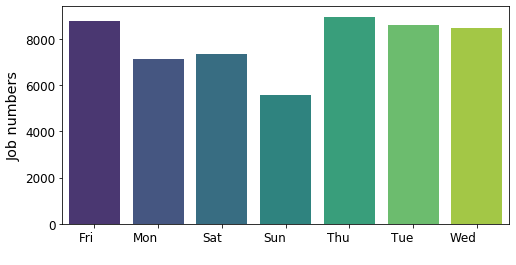

In [39]:
by_weekday = df_date_linkedin_trunc.groupby('Day of week').sum()
by_weekday.reset_index(inplace=True)
by_weekday

plt.figure(figsize=(8,4))
sns.barplot(x='Day of week', y='Jobnums', data=by_weekday, palette='viridis')
plt.xticks(horizontalalignment='right', fontweight='light', fontsize='large')
plt.yticks(fontsize='large')
plt.ylabel('Job numbers', fontsize='x-large')
plt.xlabel(' ')

## Combine with COVID-19 

In [40]:
df_covid_trunc = bydate_us['2020-05-19':'2020-08-15']

df_combined_linkedin = pd.concat([df_date_linkedin_trunc, df_covid_trunc], axis=1)
df_combined_linkedin

,Date,Jobnums,Day of week,Weekend,Confirmed,Deaths,Recovered,Active,New,Fatality
Date,,,,,,,,,,
2020-05-19,2020-05-19,433,Tue,0,1535350,94798,289392,1151160,20449,6.174358
2020-05-20,2020-05-20,108,Wed,0,1559157,96377,294312,1168468,23807,6.181353
2020-05-21,2020-05-21,91,Thu,0,1584512,97611,298418,1188483,25355,6.160319
2020-05-22,2020-05-22,126,Fri,0,1608653,98884,350135,1159634,24141,6.147006
2020-05-23,2020-05-23,276,Sat,1,1630476,100014,361239,1169223,21823,6.134037
...,...,...,...,...,...,...,...,...,...,...
2020-08-11,2020-08-11,552,Tue,0,5141208,164527,1714960,3261721,46808,3.200162
2020-08-12,2020-08-12,597,Wed,0,5197411,166034,1753760,3277617,56203,3.194552
2020-08-13,2020-08-13,744,Thu,0,5248958,167110,1774648,3307200,51547,3.183680


In [41]:
df_combined_linkedin['New']=df_combined_linkedin['New'].astype(np.float64)
df_combined_linkedin.head()

,Date,Jobnums,Day of week,Weekend,Confirmed,Deaths,Recovered,Active,New,Fatality
Date,,,,,,,,,,
2020-05-19,2020-05-19,433,Tue,0,1535350,94798,289392,1151160,20449.0,6.174358
2020-05-20,2020-05-20,108,Wed,0,1559157,96377,294312,1168468,23807.0,6.181353
2020-05-21,2020-05-21,91,Thu,0,1584512,97611,298418,1188483,25355.0,6.160319
2020-05-22,2020-05-22,126,Fri,0,1608653,98884,350135,1159634,24141.0,6.147006
2020-05-23,2020-05-23,276,Sat,1,1630476,100014,361239,1169223,21823.0,6.134037


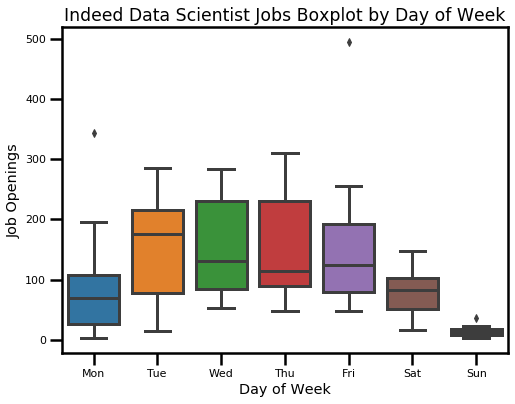

In [53]:
plt.figure(figsize=(8,6))
sns.set_context('poster',font_scale=0.5)
sns.boxplot(data=df_combined_indeed, x='Day of week', y='Jobnums',order=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.ylabel('Job Openings', fontsize='large')
plt.xlabel('Day of Week', fontsize='large')
plt.title('Indeed Data Scientist Jobs Boxplot by Day of Week', fontsize='x-large')
plt.show()

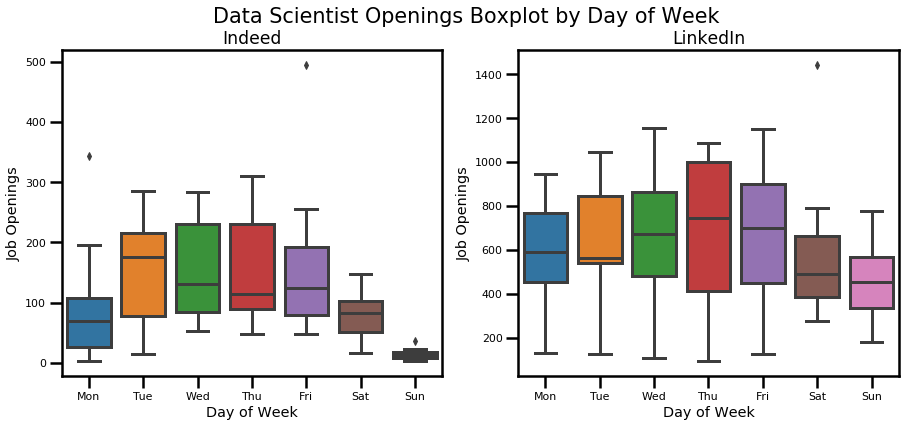

In [42]:
plt.figure(figsize=(15,6))
sns.set_context('poster',font_scale=0.5)
plt.subplot(121)
sns.boxplot(data=df_combined_indeed, x='Day of week', y='Jobnums',order=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.ylabel('Job Openings', fontsize='large')
plt.xlabel('Day of Week', fontsize='large')
plt.title('Indeed', fontsize='x-large')
plt.subplot(122)
sns.boxplot(data=df_combined_linkedin, x='Day of week', y='Jobnums',order=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.ylabel('Job Openings', fontsize='large')
plt.xlabel('Day of Week', fontsize='large')
plt.title('LinkedIn', fontsize='x-large')
plt.suptitle('Data Scientist Openings Boxplot by Day of Week', fontsize='xx-large')
plt.show()

## Grid Search

In [43]:
n_test = 7
cfg_list = varmax_configs()
method = 'walk'
scores = grid_search(df_combined_linkedin[['New','Jobnums']], cfg_list, n_test, method)
print('n_test:{}, method:{}, best_cfg parameters are:{}, rmse:{}'.format(n_test,method,scores[0][0],scores[0][1]))
#model_summary = model_summary.append({'n_test':n_test, 'validation':method, 'data':'LinkedIn', 'model':'No eXog', 'best_param':scores[0][0], 'rmse':scores[0][1]},ignore_index=True)

---> Model[[(3, 0), 'n', 1]] 79.525
---> Model[[(3, 0), 'n', 2]] 105.339
---> Model[[(3, 0), 'n', 0]] 94.374
---> Model[[(3, 0), 'c', 0]] 99.727
---> Model[[(3, 0), 'c', 1]] 82.467
---> Model[[(3, 0), 'c', 2]] 105.665
---> Model[[(3, 0), 't', 1]] 80.960
---> Model[[(3, 0), 't', 0]] 121.799
---> Model[[(3, 0), 't', 2]] 105.685
---> Model[[(3, 0), 'ct', 0]] 165.463
---> Model[[(3, 0), 'ct', 1]] 77.112
---> Model[[(3, 0), 'ct', 2]] 108.427
---> Model[[(3, 1), 'n', 0]] 96.771
---> Model[[(3, 1), 'n', 1]] 86.839
---> Model[[(3, 1), 'n', 2]] 85.490
---> Model[[(3, 1), 'c', 0]] 95.883
---> Model[[(3, 1), 'c', 1]] 98.139
---> Model[[(3, 1), 'c', 2]] 98.753
---> Model[[(3, 1), 't', 0]] 84.889
---> Model[[(3, 1), 't', 1]] 91.338
---> Model[[(3, 1), 't', 2]] 63.841
---> Model[[(3, 1), 'ct', 0]] 111.435
---> Model[[(3, 1), 'ct', 1]] 80.918
---> Model[[(3, 1), 'ct', 2]] 66.590
---> Model[[(3, 2), 'n', 0]] 81.321
---> Model[[(3, 2), 'n', 1]] 93.528
---> Model[[(3, 2), 'n', 2]] 82.571
---> Model[[(3,

---> Model[[(9, 0), 't', 1]] 171.131
---> Model[[(9, 0), 't', 2]] 170.305
---> Model[[(9, 0), 'ct', 0]] 189.529
---> Model[[(9, 0), 'ct', 1]] 167.953
---> Model[[(9, 1), 'n', 0]] 126.325
---> Model[[(9, 0), 'ct', 2]] 169.417
---> Model[[(9, 1), 'n', 1]] 180.431
---> Model[[(9, 1), 'n', 2]] 186.054
---> Model[[(9, 1), 'c', 0]] 142.444
---> Model[[(9, 1), 'c', 1]] 182.981
---> Model[[(9, 1), 'c', 2]] 180.331
---> Model[[(9, 1), 't', 0]] 128.787
---> Model[[(9, 1), 't', 1]] 189.328
---> Model[[(9, 1), 't', 2]] 202.070
---> Model[[(9, 1), 'ct', 0]] 199.646
---> Model[[(9, 1), 'ct', 1]] 178.324
---> Model[[(9, 2), 'n', 0]] 129.916
---> Model[[(9, 1), 'ct', 2]] 188.476
---> Model[[(9, 2), 'n', 1]] 187.442
---> Model[[(9, 2), 'c', 0]] 151.320
---> Model[[(9, 2), 'n', 2]] 152.235
---> Model[[(9, 2), 'c', 1]] 186.350
---> Model[[(9, 2), 'c', 2]] 136.390
---> Model[[(9, 2), 't', 0]] 132.122
---> Model[[(9, 2), 't', 1]] 200.591
---> Model[[(9, 2), 't', 2]] 145.170
---> Model[[(9, 2), 'ct', 0]] 19

In [76]:
best_cfg = [(3, 2), 'ct', 2]
n_test = 7
data = df_combined_linkedin[['New','Jobnums']]
train, test = train_test_split(data, n_test)
yhat_li_varma, error_li_varma = walk_forward_best(data, n_test, best_cfg)

### X=Weekend

In [44]:
n_test = 7
cfg_list = varmax_configs()
method = 'walk'
scores = grid_search(df_combined_linkedin[['New','Jobnums']], cfg_list, n_test, method,exog=df_combined_linkedin[['Weekend']])
print('n_test:{}, method:{}, best_cfg parameters are:{}, rmse:{}'.format(n_test,method,scores[0][0],scores[0][1]))
#model_summary = model_summary.append({'n_test':n_test, 'validation':method, 'data':'LinkedIn', 'model':'X=weekend', 'best_param':scores[0][0], 'rmse':scores[0][1]},ignore_index=True)

---> Model[[(3, 0), 'n', 0]] 108.899
---> Model[[(3, 0), 'n', 1]] 93.915
---> Model[[(3, 0), 'n', 2]] 135.987
---> Model[[(3, 0), 'c', 0]] 104.082
---> Model[[(3, 0), 'c', 1]] 119.230
---> Model[[(3, 0), 'c', 2]] 151.039
---> Model[[(3, 0), 't', 0]] 118.848
---> Model[[(3, 0), 't', 1]] 120.626
---> Model[[(3, 0), 't', 2]] 150.178
---> Model[[(3, 0), 'ct', 1]] 143.006
---> Model[[(3, 0), 'ct', 0]] 154.004
---> Model[[(3, 0), 'ct', 2]] 162.437
---> Model[[(3, 1), 'n', 0]] 112.728
---> Model[[(3, 1), 'n', 1]] 112.805
---> Model[[(3, 1), 'n', 2]] 132.804
---> Model[[(3, 1), 'c', 0]] 91.159
---> Model[[(3, 1), 'c', 1]] 155.595
---> Model[[(3, 1), 'c', 2]] 149.223
---> Model[[(3, 1), 't', 0]] 83.623
---> Model[[(3, 1), 't', 1]] 123.296
---> Model[[(3, 1), 't', 2]] 113.518
---> Model[[(3, 1), 'ct', 0]] 102.616
---> Model[[(3, 1), 'ct', 1]] 164.856
---> Model[[(3, 1), 'ct', 2]] 166.815
---> Model[[(3, 2), 'n', 0]] 119.987
---> Model[[(3, 2), 'n', 1]] 99.068
---> Model[[(3, 2), 'c', 0]] 95.131


---> Model[[(9, 0), 'c', 2]] 221.241
---> Model[[(9, 0), 't', 0]] 132.176
---> Model[[(9, 0), 't', 1]] 180.075
---> Model[[(9, 0), 't', 2]] 180.602
---> Model[[(9, 0), 'ct', 0]] 190.527
---> Model[[(9, 0), 'ct', 1]] 195.662
---> Model[[(9, 0), 'ct', 2]] 265.748
---> Model[[(9, 1), 'n', 0]] 125.522
---> Model[[(9, 1), 'n', 1]] 169.893
---> Model[[(9, 1), 'n', 2]] 184.426
---> Model[[(9, 1), 'c', 0]] 148.862
---> Model[[(9, 1), 'c', 1]] 178.830
---> Model[[(9, 1), 'c', 2]] 254.845
---> Model[[(9, 1), 't', 0]] 129.297
---> Model[[(9, 1), 't', 1]] 200.717
---> Model[[(9, 1), 't', 2]] 190.794
---> Model[[(9, 1), 'ct', 0]] 196.082
---> Model[[(9, 1), 'ct', 1]] 185.882
---> Model[[(9, 1), 'ct', 2]] 298.561
---> Model[[(9, 2), 'n', 0]] 198.600
---> Model[[(9, 2), 'n', 1]] 174.661
---> Model[[(9, 2), 'n', 2]] 148.466
---> Model[[(9, 2), 'c', 0]] 162.132
---> Model[[(9, 2), 'c', 1]] 166.693
---> Model[[(9, 2), 'c', 2]] 219.392
---> Model[[(9, 2), 't', 0]] 132.651
---> Model[[(9, 2), 't', 1]] 192

In [77]:
n_test = 7
best_cfg = [(5, 2), 'c', 0]
data = df_combined_linkedin[['New','Jobnums']]
train, test = train_test_split(data, n_test)
yhat_li_varmax, error_li_varmax = walk_forward_best(data, n_test, best_cfg, exog=df_combined_linkedin[['Weekend']])

In [78]:
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{"colspan": 2}, None],[{}, {}]],
    subplot_titles=("Train data",'No eXog, RMSE: {:0.2f}'.format(error_li_varma), 'X=Weekend, RMSE: {:0.2f}'.format(error_li_varmax)))

fig.add_trace(go.Scatter(x=train.index, y=train['Jobnums'], mode='lines+markers',name='Train', showlegend=False), row=1, col=1)
fig.add_trace(go.Scatter(x=test.index, y=test['Jobnums'], mode='lines+markers',line=dict(color='green'), name='Test', showlegend=False), row=2, col=1)
fig.add_trace(go.Scatter(x=test.index, y=yhat_li_varma["Jobnums"], mode='lines+markers',line=dict(color='red'), name='Prediction',showlegend=False),row=2, col=1)
#fig.add_trace(go.Scatter(x=pred_cix.index, y=pred_ci.iloc[:,1], fill=None, mode='lines',line=dict(width=0.0,color='lightgray'),showlegend=False), row=2, col=1)
#fig.add_trace(go.Scatter(x=pred_cix.index, y=pred_ci.iloc[:,3], fill='tonexty', mode='lines',line=dict(width=0.0,color='lightgray'),showlegend=False),row=2, col=1)
fig.add_trace(go.Scatter(x=test.index, y=test['Jobnums'], mode='lines+markers', line=dict(color='green'), name='Test',showlegend=True), row=2, col=2)
fig.add_trace(go.Scatter(x=test.index, y=yhat_li_varmax["Jobnums"], mode='lines+markers', line=dict(color='red'), name='Prediction',showlegend=True),row=2, col=2)
#fig.add_trace(go.Scatter(x=pred_cix.index, y=pred_u, fill=None, mode='lines',line=dict(width=0.0,color='lightgray'),showlegend=False), row=2, col=2)
#fig.add_trace(go.Scatter(x=pred_cix.index, y=pred_l, fill='tonexty', mode='lines',line=dict(width=0.0,color='lightgray'),showlegend=False),row=2, col=2)
fig.update_layout(title='LinkedIn Data Scientist Job Openings Forecast via VARMAX Model',legend=dict(x=1,y=0.25))
fig.show()

### Forecast the future

In [64]:
df_linkedin_future = pd.DataFrame(columns=['Date', 'Day of week', 'Weekend'])
df_linkedin_future['Date'] = pd.date_range('2020-08-16', '2020-08-22')
df_linkedin_future.set_index('Date', inplace=True, drop=False)
df_linkedin_future['Day of week'] = df_indeed_future['Date'].apply(lambda x: week[x.weekday()])
df_linkedin_future['Weekend'] = df_indeed_future['Day of week'].apply(lambda x: 1 if (x=='Sun') or (x=='Sat') else 0)
df_linkedin_future

,Date,Day of week,Weekend
Date,,,
2020-08-16,2020-08-16,Sun,1
2020-08-17,2020-08-17,Mon,0
2020-08-18,2020-08-18,Tue,0
2020-08-19,2020-08-19,Wed,0
2020-08-20,2020-08-20,Thu,0
2020-08-21,2020-08-21,Fri,0
2020-08-22,2020-08-22,Sat,1


In [79]:
n_test = 7
best_cfg = [(5, 2), 'c', 0]
train = df_combined_linkedin[['New','Jobnums']]
exog_train = df_combined_linkedin[['Weekend']]
exog_test = df_linkedin_future[['Weekend']]
linkedin_pred = pd.DataFrame()
history = train.copy()
exog_ = [x[:] for x in exog_train.values]
for i in range(n_test):
    yhat = varmax_forecast(history, 1, best_cfg, exog1=exog_, exog2=np.array(exog_test.iloc[i]).reshape(1,-1))
    linkedin_pred = linkedin_pred.append(yhat)
    history = history.append(yhat)
    exog_.append(np.array(exog_test.iloc[i]))

In [80]:
fig = go.Figure()

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="x",
            yref="paper",
            x0=df_linkedin_future.index[0],
            y0=0,
            x1=df_linkedin_future.index[-1],
            y1=1,
            fillcolor="LightSalmon",
            opacity=0.2,
            layer="below",
            line_width=0,
        )
    ]
)

fig.add_trace(go.Scatter(x=df_combined_linkedin.index, y=df_combined_linkedin['Jobnums'], mode='lines+markers', 
                         marker=dict(size=8, color='royalblue'), name='Train'))

fig.add_trace(go.Scatter(x=df_linkedin_future.index, y=linkedin_pred['Jobnums'], mode='lines+markers', 
                         marker=dict(size=8, color='red'), name='Future Forecast'))


fig.add_annotation(
            x='2020-08-18',
            y=750,
            text="Future<br>forecast",
            font=dict(size=16),
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            ax=10,
            ay=-70,)

fig.update_layout(title={'text': "LinkedIn Data Scientist Open Positions Future Forecast (VARMAX Model)", 
                         'y':0.9, 'x':0.52,
                         'xanchor': 'center',
                         'yanchor': 'top'},
                  width=900,
                  height=500,
                  titlefont=dict(size=20),
                  xaxis=dict(title=dict(text='Post date', standoff=0), titlefont=dict(size=18), tickfont=dict(size=16)),
                  yaxis=dict(title=dict(text='Job numbers'), titlefont=dict(size=18), tickfont=dict(size=16)),
                  legend=dict(font=dict(size=16), x=0.05, y=0.95),
                  margin = {'r':10, 'l': 0, 't':90, 'b':0}
                 )
fig.show()

In [81]:
linkedin_ds = pd.DataFrame(columns=['Source','Test_date','Yhat_varma','Yhat_varmax','Future_date','Forecast_varmax'])
linkedin_ds['Source'] = 'LinkedIn_DS'
linkedin_ds['Test_date'] = test.index
linkedin_ds['Yhat_varma'] = yhat_li_varma['Jobnums'].values
linkedin_ds['Yhat_varmax'] = yhat_li_varmax['Jobnums'].values
linkedin_ds['Future_date'] = df_linkedin_future.index
linkedin_ds['Forecast_varmax'] = linkedin_pred['Jobnums'].values
linkedin_ds.loc[:,'Source'] = 'LinkedIn_DS'
linkedin_ds

,Source,Test_date,Yhat_varma,Yhat_varmax,Future_date,Forecast_varmax
0,LinkedIn_DS,2020-08-09,549.455028,605.865936,2020-08-16,413.877435
1,LinkedIn_DS,2020-08-10,449.458831,522.479883,2020-08-17,603.853651
2,LinkedIn_DS,2020-08-11,550.142644,586.518102,2020-08-18,598.374612
3,LinkedIn_DS,2020-08-12,525.387808,592.652019,2020-08-19,746.627196
4,LinkedIn_DS,2020-08-13,639.878801,667.537542,2020-08-20,615.238074
5,LinkedIn_DS,2020-08-14,558.431746,646.637375,2020-08-21,678.706736
6,LinkedIn_DS,2020-08-15,520.401247,554.093101,2020-08-22,554.511686


In [82]:
ds_combined = indeed_ds.append(linkedin_ds)
ds_combined

,Source,Test_date,Yhat_varma,Yhat_varmax,Future_date,Forecast_varmax
0,Indeed_DS,2020-08-09,20.980635,36.005440,2020-08-16,95.398523
1,Indeed_DS,2020-08-10,162.067301,150.091450,2020-08-17,161.567159
2,Indeed_DS,2020-08-11,187.303514,159.933595,2020-08-18,226.551819
3,Indeed_DS,2020-08-12,223.290504,215.837825,2020-08-19,185.225254
4,Indeed_DS,2020-08-13,179.088326,187.010141,2020-08-20,261.120855
5,Indeed_DS,2020-08-14,216.299127,236.907966,2020-08-21,200.189607
6,Indeed_DS,2020-08-15,91.928873,90.116349,2020-08-22,151.479609
0,LinkedIn_DS,2020-08-09,549.455028,605.865936,2020-08-16,413.877435
1,LinkedIn_DS,2020-08-10,449.458831,522.479883,2020-08-17,603.853651
2,LinkedIn_DS,2020-08-11,550.142644,586.518102,2020-08-18,598.374612


In [83]:
ds_combined.to_csv('/Users/tingtingweng/Documents/summer_intern/data/var_ds_0815.csv',index=False)